In [2]:
!pip install optuna

In [3]:
#librarires to be installed
import os,sys
import numpy as np
import pandas as pd 
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
from IPython.display import clear_output
from albumentations import *

In [4]:
#all required torch libraries
import torch
import torchvision
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms,utils
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torchvision.transforms import ToPILImage
from torch.utils.data.dataset import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [8]:
import time
import optuna
import csv
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("finished")
from os import listdir
from os.path import isfile, join

finished


In [6]:
def resize(path):
  dirs = os.listdir( path )
  for item in tqdm(dirs):
    if os.path.isfile(path+item):
      im = Image.open(path+item)
      f, e = os.path.splitext(path+item)
      imResize = im.resize((256,256), Image.NEAREST)
      imResize.save(f+e, 'PNG', quality=100)
      
features_path, label_path = "/kaggle/input/nucleus-data-c-elegans/nucleus_data/features", "/kaggle/input/nucleus-data-c-elegans/nucleus_data/segmentation_maps"
resize(label_path)
resize(features_path)

  0%|          | 0/6790 [00:00<?, ?it/s]

  0%|          | 0/6756 [00:00<?, ?it/s]

In [9]:
ids=[]
label_filenames = [f for f in listdir(label_path) if isfile(join(label_path, f))]
feature_filenames = [f for f in listdir(features_path) if isfile(join(features_path, f))]
for i in range(len(label_filenames)):
  ids.append(label_filenames[i][1:])
print(len(ids))

df = pd.DataFrame(ids ,columns=["file_ids"])
df.to_csv('file_ids.csv', index=False)

#sanity check
df = pd.read_csv('file_ids.csv')
df.head()

6790


,file_ids
0,59_8.png
1,47_29.png
2,138_11.png
3,94_6.png
4,57_4.png


In [11]:
class SegmentationDataset(Dataset):   
    def __init__(self, csv, augmentation =None, transform_image = None, transform_label = None):

        self.df = pd.read_csv(csv)
        self.ids  = self.df["file_ids"]
        self.transform_image = transform_image
        self.transform_label = transform_label
        self.augmentation = augmentation

    def __getitem__(self, idx):
        image= np.array(Image.open("/kaggle/input/nucleus-data-c-elegans/nucleus_data/features/F"+self.ids[idx]))
        mask=np.array(Image.open("/kaggle/input/nucleus-data-c-elegans/nucleus_data/segmentation_maps/L"+self.ids[idx]))
        if self.augmentation is not None:
                
            augmented  = self.augmentation(image = image, mask = mask)
            image = augmented["image"]
            mask = augmented["mask"]
       
        
        mask = self.transform_label(mask)
        mask = mask.float()
        return self.transform_image(image), mask
    
    def __len__(self):
        return len(self.ids)
    
    
    


In [13]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [14]:
full_dataset = SegmentationDataset(csv = "file_ids.csv",
                                    augmentation =  Compose([
                                                            #GridDistortion(p=0.5),
                                                            Transpose(p=0.5),
                                                            VerticalFlip(p=0.5),
                                                            HorizontalFlip(p=0.5),
                                                            RandomRotate90(p=0.5),
                                                            ShiftScaleRotate(p=0.1),
                                                            OpticalDistortion(distort_limit=0.3, shift_limit=0.3, p=1),
                                                            ]),

                                    transform_image = transforms.Compose([ 
                                                                    
                                                                    transforms.ToPILImage(),
                                                                    ToTensor(),
                                                                    transforms.RandomApply([AddGaussianNoise( mean = 0.5,std= 0.05)], p=0.5)
                                                                ]),                                  
                                    transform_label = transforms.Compose([ 
                                                                                                      
                                                                    transforms.ToPILImage(),
                                                                    ToTensor(),

                                                                ]))

In [15]:
train_batch_size = 32
train_size = int(0.8* len(full_dataset))  ## 80/20 split
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=test_dataset, batch_size= 4, shuffle = True)

print(len(train_loader), "batches ")
print(len(val_loader), " batches ")
sample = next(iter(train_loader))

340 batches 
340  batches 


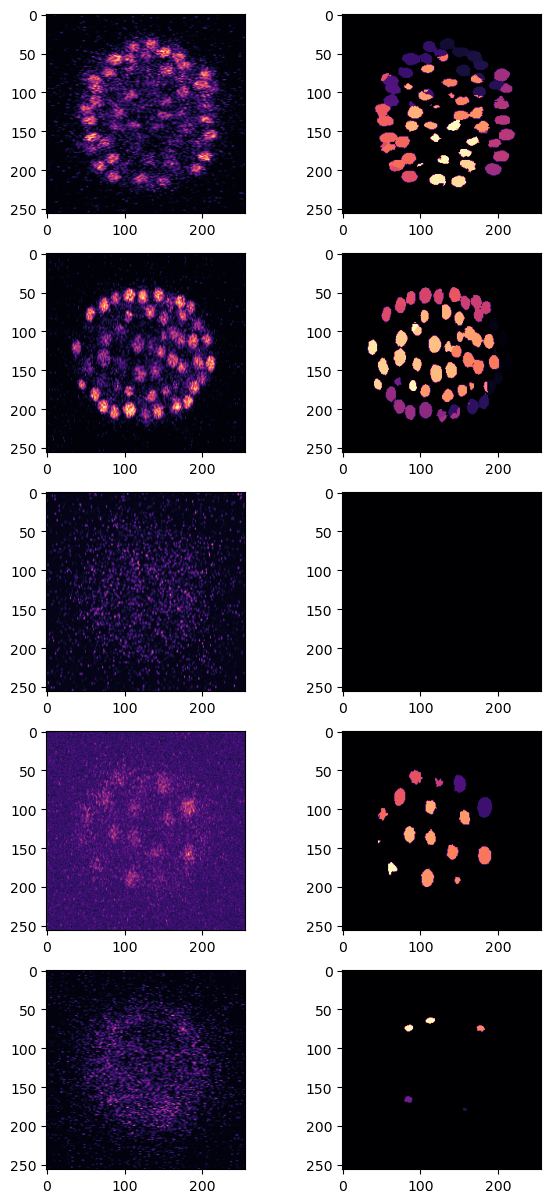

In [17]:
batch  = next(iter(train_loader))
images, masks = batch
fig, ax = plt.subplots(5, 2, figsize = (7,15))
for i in range(5):
    ax[i][0].imshow(images[i][0], cmap='magma')
    ax[i][1].imshow(masks[i][0], cmap='magma')